The purpose of this project is to use data on United States vaccination rates, population, and travel statistics to predict locations within the US that will be safe to travel to in the near future.

In [1]:
import numpy as np
import pandas as pd
import csv
import requests
import io
import datetime
import matplotlib.pyplot as plt
import seaborn as sns
import keras
import tensorflow as tf
from keras.models import Sequential
from keras.layers import LSTM, Dense, Dropout
from keras.optimizers import SGD
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from keras.preprocessing.sequence import TimeseriesGenerator
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score
from math import sqrt
import plotly.graph_objects as go

The first dataset we will be using was accessed at: https://www.kaggle.com/bumjunkoo/us-vaccination-progress 
This dataset goes back to 1/12/21 and we sourced it on 7/6/21. This gave us nearly 6 months of data on vaccination statistics in the US. Initially we are building an example model with just one day's worth of data.

In [2]:
#Loading the initial state vaccination csv.
data = pd.read_csv('us_state_vaccinations.csv')
data['date'] = data['date'].astype('datetime64[ns]')
data['state'] = data['location']
data['vaxxed_per_hundred'] = data['people_fully_vaccinated_per_hundred']

display(data.isnull().sum())
safe = data[data['vaxxed_per_hundred'] > 45]
print(safe.shape)
#Extrapolating the needed data into a new dataframe.
cut = data.drop(columns = ['total_distributed', 'people_fully_vaccinated_per_hundred','location','people_vaccinated', 
                           'total_vaccinations_per_hundred', 'people_vaccinated_per_hundred', 'distributed_per_hundred'
                           , 'daily_vaccinations_raw', 'daily_vaccinations_per_million', 'share_doses_used'])

new = cut.loc[(cut['date'] == '2021-07-06')]
new = new.replace({"state": "New York State"}, "New York")
print(new.head())

us = cut.loc[(cut['state'] == 'United States')]
us['vaxxed_per_hundred'] = us['vaxxed_per_hundred'].interpolate(method='linear', limit_direction='forward')

date                                      0
location                                  0
total_vaccinations                      400
total_distributed                       580
people_vaccinated                       592
people_fully_vaccinated_per_hundred    1214
total_vaccinations_per_hundred         1112
people_fully_vaccinated                 674
people_vaccinated_per_hundred          1137
distributed_per_hundred                1125
daily_vaccinations_raw                   65
daily_vaccinations                       65
daily_vaccinations_per_million          800
share_doses_used                        580
state                                     0
vaxxed_per_hundred                     1214
dtype: int64

(1100, 16)
          date  total_vaccinations  people_fully_vaccinated  \
175 2021-07-06           3392366.0                1617584.0   
351 2021-07-06            678029.0                 322988.0   
527 2021-07-06             47310.0                  21583.0   
703 2021-07-06           6826215.0                3172380.0   
879 2021-07-06           2261649.0                1043217.0   

     daily_vaccinations           state  vaxxed_per_hundred  
175              6066.0         Alabama               32.99  
351              3219.0          Alaska               44.15  
527               172.0  American Samoa               38.76  
703             48692.0         Arizona               43.58  
879              5162.0        Arkansas               34.57  


<ipython-input-2-ee3e0a5f5004>:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  us['vaxxed_per_hundred'] = us['vaxxed_per_hundred'].interpolate(method='linear', limit_direction='forward')


The figure below shows the steady increase of vaccinations within the US over the past 6 months.

Text(0.5, 1.0, 'US Vaccinations')

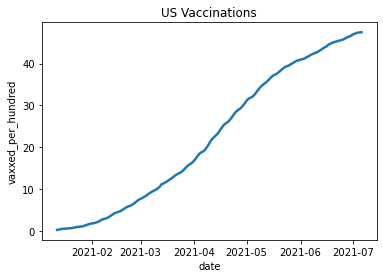

In [3]:
# Visualizing US vaccinations
f, ax = plt.subplots(figsize=(6, 4))
sns.lineplot(data=us, x = 'date', y = 'vaxxed_per_hundred', palette="tab10", linewidth=2.5)
plt.title('US Vaccinations')

The next dataset we sourced from the New York Times GitHub at: https://github.com/nytimes/covid-19-data
This dataset is regularly updated and dates back to 1/21/2020, the very beginning of the pandemic in the United States. We decided to make use of the rolling average dataset for states in the US.

In [4]:
url = "https://raw.githubusercontent.com/nytimes/covid-19-data/master/rolling-averages/us-states.csv" 
download = requests.get(url).content

#Creating a new dataframe for rolling average values

rolling_avg = pd.read_csv(io.StringIO(download.decode('utf-8')))

rolling_avg['date'] = pd.to_datetime(rolling_avg['date'], format='%Y-%m-%d')

#Extrapolating needed data into a new rolling average dataframe.
rolling_avg = rolling_avg.drop(columns = ['geoid', 'cases', 'deaths', 'deaths_avg_per_100k'])

raNew = rolling_avg.loc[(rolling_avg['date'] =='2021-07-06')]
raNew.head()

,date,state,cases_avg,cases_avg_per_100k,deaths_avg
26964,2021-07-06,Northern Mariana Islands,0.00,0.00,0.00
26965,2021-07-06,Guam,6.57,3.90,0.00
26966,2021-07-06,Puerto Rico,55.00,1.62,0.71
26967,2021-07-06,Virgin Islands,12.00,11.30,0.00
26968,2021-07-06,Wyoming,63.86,11.03,0.57


The following figure illustrates the surge and decline of Covid-19 cases in the United States over the past 18 months.

<AxesSubplot:title={'center':'US Covid Cases'}, xlabel='date'>

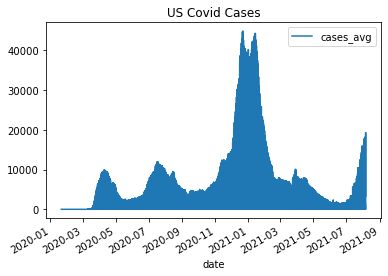

In [5]:
rolling_avg.plot.line(x = 'date', y = 'cases_avg', title= 'US Covid Cases')

The third source of data was accessed from the Johns Hopkins GitHub at: https://github.com/CSSEGISandData/COVID-19/tree/master/csse_covid_19_data
The repository is updated daily and goes back to 1/1/2021. This was where we expected to source much of our data. Unfortunately, attributes such as "Recovered" and "Active" were not reported in more recent updates.

In [6]:
url_2 = "https://raw.githubusercontent.com/CSSEGISandData/COVID-19/master/csse_covid_19_data/csse_covid_19_daily_reports_us/07-05-2021.csv"
dl = requests.get(url_2).content

#Loading the initial dataframe for the master covid data
jH = pd.read_csv(io.StringIO(dl.decode('utf-8')))

jH['state'] = jH['Province_State']

#Extrapolating the needed data into a new dataframe
jHnew = jH.drop(columns = ['Last_Update','Province_State','Country_Region','Lat', 'Long_', 'FIPS', 'Total_Test_Results', 'People_Hospitalized', 'UID', 'ISO3', 
                           'Testing_Rate', 'Hospitalization_Rate'])

jHnew.head()

,Confirmed,Deaths,Recovered,Active,Incident_Rate,Case_Fatality_Ratio,state
0,551298,11358,NaN,NaN,11243.671206,2.060229,Alabama
1,71384,377,NaN,NaN,9757.977978,0.528130,Alaska
2,0,0,NaN,NaN,0.000000,NaN,American Samoa
3,897010,17979,NaN,NaN,12323.737824,2.004325,Arizona
4,351825,5920,NaN,NaN,11658.311806,1.682655,Arkansas


In the following cell, we bring together our three initial datasets.

In [7]:
#Merging 2 Dataframes together
dos = pd.merge(new, raNew, on=['state','date'])
dos
dos['date'] = pd.to_datetime(dos['date'], format='%Y-%m-%d')
#Merging the Created dataframe and the master data together
all3 = pd.merge(dos, jHnew, on='state')

all3 = all3[['date', 'state', 'vaxxed_per_hundred', 'people_fully_vaccinated', 'Confirmed','cases_avg', 'deaths_avg','Deaths', 'Recovered', 
            'Active', 'Incident_Rate', 'Case_Fatality_Ratio', 'daily_vaccinations','total_vaccinations']]

#doing the math for recovered
all3['Recovered'] = all3['Confirmed'] - all3['Deaths']

#Displaying the new merged dataframe
all3.head()

,date,state,vaxxed_per_hundred,people_fully_vaccinated,Confirmed,cases_avg,deaths_avg,Deaths,Recovered,Active,Incident_Rate,Case_Fatality_Ratio,daily_vaccinations,total_vaccinations
0,2021-07-06,Alabama,32.99,1617584.0,551298,121.00,2.86,11358,539940,NaN,11243.671206,2.060229,6066.0,3392366.0
1,2021-07-06,Alaska,44.15,322988.0,71384,27.57,0.43,377,71007,NaN,9757.977978,0.528130,3219.0,678029.0
2,2021-07-06,Arizona,43.58,3172380.0,897010,543.43,10.00,17979,879031,NaN,12323.737824,2.004325,48692.0,6826215.0
3,2021-07-06,Arkansas,34.57,1043217.0,351825,485.14,3.00,5920,345905,NaN,11658.311806,1.682655,5162.0,2261649.0
4,2021-07-06,California,50.49,19949682.0,3821572,1504.40,32.20,63655,3757917,NaN,9671.872929,1.665545,95566.0,43182509.0


In order to have a source of input for active Covid cases, we again used the New York Times GitHub repository. This gave us data on confirmed active Covid cases for each state. This data goes back to 1/22/2020.

In [8]:
url_3 = "https://raw.githubusercontent.com/datasets/covid-19/main/data/us_confirmed.csv"
dl3 = requests.get(url_3).content

#adding data from a 3rd dataframe for confirmed active covid cases by state

confirmed = pd.read_csv(io.StringIO(dl3.decode('utf-8')),  error_bad_lines=False)

C:\Users\Agent\anaconda3\lib\site-packages\IPython\core\interactiveshell.py:3437: FutureWarning: The error_bad_lines argument has been deprecated and will be removed in a future version.


  exec(code_obj, self.user_global_ns, self.user_ns)


In [9]:
#Configuring the dataframe, dropping unnecessary or redundant values/changing column names to match.

confirmed['Date'] = pd.to_datetime(confirmed['Date'], format='%Y-%m-%d')
confirmed['date'] = confirmed['Date']
confirmed['state'] = confirmed['Province/State']
confirmed['Active'] = confirmed['Case']
confirmed.drop(columns=['Admin2', 'Date', 'Province/State', 'Country/Region', 'Case'], inplace=True)
display(confirmed.head())

,date,state,Active
0,2020-01-22,Alabama,0
1,2020-01-23,Alabama,0
2,2020-01-24,Alabama,0
3,2020-01-25,Alabama,0
4,2020-01-26,Alabama,0


The following figure shows Covid cases over the past 18 months.

Text(0.5, 1.0, 'US Covid Cases')

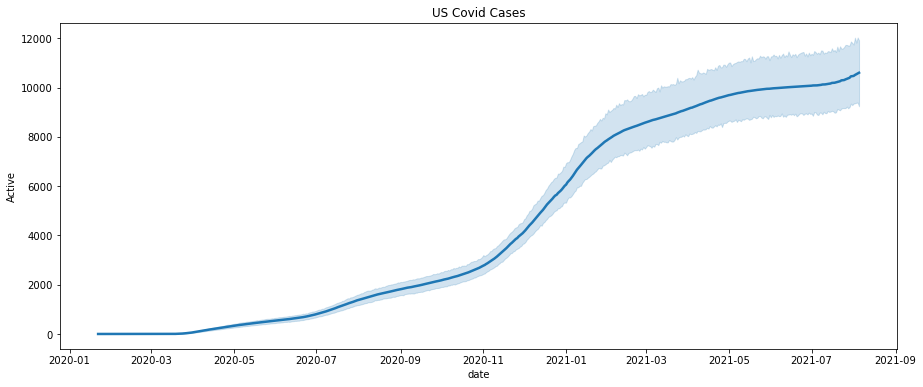

In [10]:
f, ax = plt.subplots(figsize=(15, 6))
sns.lineplot(data=confirmed, x = 'date', y = 'Active', palette="tab10", linewidth=2.5)
plt.title('US Covid Cases')

In [11]:
#retrieving active cases from the confirmed dataframe from the 6th, to be used for an example.

result = confirmed[confirmed['date'] == '2021-07-06']

#retreiving the highest active instances for the day, grouped by state.
result = result.loc[result.groupby('state')['Active'].idxmax(), :].reset_index()
result = result.drop(columns=['index'])
result.head()

,date,state,Active
0,2021-07-06,Alabama,81328
1,2021-07-06,Alaska,31286
2,2021-07-06,American Samoa,0
3,2021-07-06,Arizona,562308
4,2021-07-06,Arkansas,41703


In [12]:
#Mapping the highest active value by state to the values of the all3['state'] column based on like data.
all3['Active'] = all3.state.map(dict(zip(result.state, result.Active)))
all3.head()

,date,state,vaxxed_per_hundred,people_fully_vaccinated,Confirmed,cases_avg,deaths_avg,Deaths,Recovered,Active,Incident_Rate,Case_Fatality_Ratio,daily_vaccinations,total_vaccinations
0,2021-07-06,Alabama,32.99,1617584.0,551298,121.00,2.86,11358,539940,81328,11243.671206,2.060229,6066.0,3392366.0
1,2021-07-06,Alaska,44.15,322988.0,71384,27.57,0.43,377,71007,31286,9757.977978,0.528130,3219.0,678029.0
2,2021-07-06,Arizona,43.58,3172380.0,897010,543.43,10.00,17979,879031,562308,12323.737824,2.004325,48692.0,6826215.0
3,2021-07-06,Arkansas,34.57,1043217.0,351825,485.14,3.00,5920,345905,41703,11658.311806,1.682655,5162.0,2261649.0
4,2021-07-06,California,50.49,19949682.0,3821572,1504.40,32.20,63655,3757917,1253106,9671.872929,1.665545,95566.0,43182509.0


In order to calculate percentages of the states' populations which are vaccinated, we accessed United States Census Bureau data at: https://www.census.gov/data/datasets/time-series/demo/popest/2010s-state-total.html#par_textimage_1873399417
This gave us a good estimate for population to work with.

In [13]:
#Adding an additional datasource for population estimation, will be used to determine the %of the pop infected 
#as well as the % of the pop vaccinated
state_df = pd.read_csv('Population_of_US.csv', delimiter=',')
m1 = state_df['POPESTIMATE2019']
m2 = state_df['NAME']
state_df = pd.DataFrame({'state' : m2, 'population_est' : m1}, index=np.arange(len(m1)))
state_df = state_df.replace({"state": "New York State"}, "New York")
state_df.head()

,state,population_est
0,Alabama,4903185
1,Alaska,731545
2,Arizona,7278717
3,Arkansas,3017804
4,California,39512223


We calculated the percentage of each state's population which is vaccinated and the percentage which may be infected on a given date.

In [14]:
all3['total_state_pop'] = all3.state.map(dict(zip(state_df.state, state_df.population_est)))
all3.dropna(inplace=True)
all3['%_pop_vaxxed'] = round((all3['people_fully_vaccinated'] / all3['total_state_pop']) *100, 2)
all3['%_pop_infected'] = round((all3['Active'] / all3['total_state_pop']) *100, 2)
#outputting an example training dataframe displaying one day's data
all3.head()

,date,state,vaxxed_per_hundred,people_fully_vaccinated,Confirmed,cases_avg,deaths_avg,Deaths,Recovered,Active,Incident_Rate,Case_Fatality_Ratio,daily_vaccinations,total_vaccinations,total_state_pop,%_pop_vaxxed,%_pop_infected
0,2021-07-06,Alabama,32.99,1617584.0,551298,121.00,2.86,11358,539940,81328,11243.671206,2.060229,6066.0,3392366.0,4903185.0,32.99,1.66
1,2021-07-06,Alaska,44.15,322988.0,71384,27.57,0.43,377,71007,31286,9757.977978,0.528130,3219.0,678029.0,731545.0,44.15,4.28
2,2021-07-06,Arizona,43.58,3172380.0,897010,543.43,10.00,17979,879031,562308,12323.737824,2.004325,48692.0,6826215.0,7278717.0,43.58,7.73
3,2021-07-06,Arkansas,34.57,1043217.0,351825,485.14,3.00,5920,345905,41703,11658.311806,1.682655,5162.0,2261649.0,3017804.0,34.57,1.38
4,2021-07-06,California,50.49,19949682.0,3821572,1504.40,32.20,63655,3757917,1253106,9671.872929,1.665545,95566.0,43182509.0,39512223.0,50.49,3.17


The following figure shows the percentage of the population of each state which was vaccinated as of 7/6/2021.

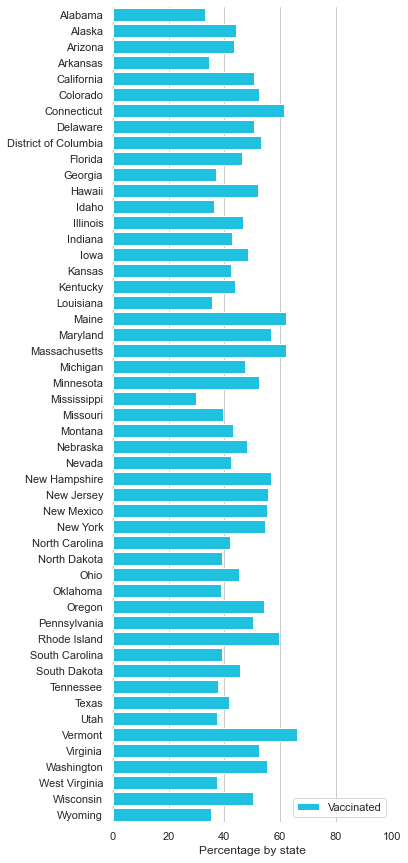

In [15]:
sns.set_theme(style="whitegrid")

f, ax = plt.subplots(figsize=(5, 15))


sns.set_color_codes("bright")
sns.barplot(x="%_pop_vaxxed", y="state", data=all3,
            label="Vaccinated", color="c")

ax.legend(ncol=2, loc="lower right", frameon=True)
ax.set(xlim=(0, 100), ylabel="",
       xlabel="Percentage by state")
sns.despine(left=True, bottom=True)

We have our examples based on a day's worth of data, now we will build our working model using 6 months of data from our sources. Some of our sources consist of a single csv file, which we can access locally.


In [16]:
data.head()
data['date'].unique()

xdf = pd.read_csv('us_state_vaccinations.csv')
xdf = xdf.replace({"location": "New York State"}, "New York")
xdf['date'] = xdf['date'].astype('datetime64[ns]')
xdf.dtypes

#result = result.loc[result.groupby('state')['Active'].idxmax(), :].reset_index()

date                                   datetime64[ns]
location                                       object
total_vaccinations                            float64
total_distributed                             float64
people_vaccinated                             float64
people_fully_vaccinated_per_hundred           float64
total_vaccinations_per_hundred                float64
people_fully_vaccinated                       float64
people_vaccinated_per_hundred                 float64
distributed_per_hundred                       float64
daily_vaccinations_raw                        float64
daily_vaccinations                            float64
daily_vaccinations_per_million                float64
share_doses_used                              float64
dtype: object

In [17]:
xdf = xdf.loc[xdf['date'] >= '2021-1-12']
xdf = xdf.drop(['total_distributed', 'people_vaccinated', 'total_vaccinations_per_hundred', 
                'people_vaccinated_per_hundred', 'distributed_per_hundred', 'daily_vaccinations_raw',
                'daily_vaccinations_per_million', 'share_doses_used'], axis=1)

Some of the datasets included locations which were not listed in other sources. We combed through to find the common places.

In [18]:
#dropping uncommon locations
xdf.drop(xdf.index[xdf['location'] == 'Bureau of Prisons'], inplace = True)
xdf.drop(xdf.index[xdf['location'] == 'Republic of Palau'], inplace = True)
xdf.drop(xdf.index[xdf['location'] == 'Veterans Health'], inplace = True)
xdf.drop(xdf.index[xdf['location'] == 'United States'], inplace = True)
xdf.drop(xdf.index[xdf['location'] == 'Dept of Defense'], inplace = True)
xdf.drop(xdf.index[xdf['location'] == 'Federated States of Micronesia'], inplace = True)                      
xdf.drop(xdf.index[xdf['location'] == 'Indian Health Svc'], inplace = True)            
xdf.drop(xdf.index[xdf['location'] == 'Long Term Care'], inplace = True)                     
xdf.drop(xdf.index[xdf['location'] == 'Marshall Islands'], inplace = True)                              
                     
                     
xdf.head()                     

,date,location,total_vaccinations,people_fully_vaccinated_per_hundred,people_fully_vaccinated,daily_vaccinations
0,2021-01-12,Alabama,78134.0,0.15,7270.0,NaN
1,2021-01-13,Alabama,84040.0,0.19,9245.0,5906.0
2,2021-01-14,Alabama,92300.0,NaN,NaN,7083.0
3,2021-01-15,Alabama,100567.0,0.28,13488.0,7478.0
4,2021-01-16,Alabama,NaN,NaN,NaN,7498.0


In [19]:
xdf = xdf.sort_values(["date", "location"], ascending = (True, True))

In [20]:
'''
xdf['confirmed'] = np.nan
xdf['cases_avg'] = np.nan
xdf['deaths_avg'] = np.nan
xdf['deaths'] = np.nan
xdf['recovered'] = np.nan
xdf['active'] = np.nan
xdf['incident_rate'] = np.nan
xdf['case_fatality_ratio'] = np.nan
xdf['total_state_pop'] = np.nan
xdf['%_pop_vaxxed'] = np.nan
xdf['%_pop_vaxxed'] = np.nan
xdf['%_pop_infected'] = np.nan
'''
xdf = xdf.rename(columns={"location": "state"}, errors="raise")

xdf.head()


,date,state,total_vaccinations,people_fully_vaccinated_per_hundred,people_fully_vaccinated,daily_vaccinations
0,2021-01-12,Alabama,78134.0,0.15,7270.0,NaN
176,2021-01-12,Alaska,35838.0,0.74,5400.0,NaN
352,2021-01-12,American Samoa,2124.0,0.47,260.0,NaN
528,2021-01-12,Arizona,141355.0,0.11,8343.0,NaN
704,2021-01-12,Arkansas,40879.0,0.00,8.0,NaN


In [21]:
#xdf.loc[xdf['date'] == '2021-07-06']

result1 = confirmed[confirmed['date'] <= '2021-07-06']
result1 = result1.loc[(result1['date'] >= '2021-01-12')]
result1 = result1.groupby(['date', 'state']).agg({'Active':np.max}).reset_index()
#result1 = result1.unstack()
#result1 = result1.pivot(index='date', columns='state', values='Active')
#result1 = result1.melt(id_vars=['date', 'state'], value_vars=['Active'])

#result1.loc([result1['date'] == '2021-01-13'])
result1

#retrieving the highest active instances for the day, grouped by state.
#result1 = result.loc[result.groupby('state')['Active'].idxmax(), :].reset_index()
#result1 = result.drop(columns=['index'])
xdf['active'] = np.nan

#result1.head(50)

In [22]:
#xdf['active'] = pd.merge(xdf, result1, on=['date', 'state'])

#result1['state'].unique()

In [23]:
#result1.loc[result1['state'] == 'Alabama']

result1.drop(result1.index[result1['state'] == 'Diamond Princess'], inplace = True)
result1.drop(result1.index[result1['state'] == 'Grand Princess'], inplace = True)
result1 = result1.rename(columns={"Active": "active"}, errors="raise")
#result1['state'].head(55)

In [24]:
xdf = pd.merge(xdf, result1, on=['state','date'])
#xdf['active'] = xdf['active'].interpolate(method='linear', limit_direction='both', limit=1)
#xdf['active'] = xdf['active'].fillna(xdf['active'].mean())
#xdf.dtypes
xdf = xdf.drop(['active_x'], axis=1)
xdf = xdf.rename(columns={"active_y": "active"}, errors="raise")

xdf = xdf.sort_values(by='date')

In [25]:
xdf.head()

,date,state,total_vaccinations,people_fully_vaccinated_per_hundred,people_fully_vaccinated,daily_vaccinations,active
0,2021-01-12,Alabama,78134.0,0.15,7270.0,NaN,59867
30,2021-01-12,Nevada,61653.0,0.28,8761.0,NaN,193483
31,2021-01-12,New Hampshire,50613.0,0.00,5.0,NaN,20952
32,2021-01-12,New Jersey,221045.0,0.16,14306.0,NaN,57609
33,2021-01-12,New Mexico,78235.0,0.54,11335.0,NaN,44923


In [26]:
'''
xdf = xdf.reset_index()
#xdf['daily_vaccinations'] = xdf['daily_vaccinations'].interpolate(method='linear', limit_direction='backward', limit=1)
xdf = xdf.drop(['index'],axis=1)
#xdf = xdf.drop(['level_0'],axis=1)
'''

"\nxdf = xdf.reset_index()\n#xdf['daily_vaccinations'] = xdf['daily_vaccinations'].interpolate(method='linear', limit_direction='backward', limit=1)\nxdf = xdf.drop(['index'],axis=1)\n#xdf = xdf.drop(['level_0'],axis=1)\n"

In [27]:
'''
xdf['daily_vaccinations'] = xdf['daily_vaccinations'].fillna(xdf['daily_vaccinations'].mean())
xdf['total_vaccinations'] = xdf['total_vaccinations'].interpolate()
xdf['people_fully_vaccinated_per_hundred'] = xdf['people_fully_vaccinated_per_hundred'].fillna(xdf['people_fully_vaccinated_per_hundred'].mean())
xdf['people_fully_vaccinated'] = xdf['people_fully_vaccinated'].interpolate()
xdf['active'] = xdf['active'].interpolate()
xdf.head(57)
'''

"\nxdf['daily_vaccinations'] = xdf['daily_vaccinations'].fillna(xdf['daily_vaccinations'].mean())\nxdf['total_vaccinations'] = xdf['total_vaccinations'].interpolate()\nxdf['people_fully_vaccinated_per_hundred'] = xdf['people_fully_vaccinated_per_hundred'].fillna(xdf['people_fully_vaccinated_per_hundred'].mean())\nxdf['people_fully_vaccinated'] = xdf['people_fully_vaccinated'].interpolate()\nxdf['active'] = xdf['active'].interpolate()\nxdf.head(57)\n"

The Johns Hopkins GitHub is updated daily, with a new csv file added each day. This made accessing 6 months worth of data a bit more challenging.

In [28]:
#accessing 6 months of data from JH github
jHdata = []
dates=[datetime.date(2021,1,11)+datetime.timedelta(dval) for dval in range(0,176)];
for dateval in dates:
    jdata = "https://raw.githubusercontent.com/CSSEGISandData/COVID-19/master/csse_covid_19_data/csse_covid_19_daily_reports_us/"+dateval.strftime('%m-%d-%Y')+".csv"
    jdownl = requests.get(jdata).content
    #Loading data into list
    j_temp = pd.read_csv(io.StringIO(jdownl.decode('utf-8')))
    jHdata.append(j_temp)
    
    #all data into an array in order to create dataframe
jArr = np.array(jHdata)
jArr = jArr.reshape(-1,18)
j_data = pd.DataFrame(jArr, columns=['Province_State', 'Country_Region','Last_Update', 'Lat', 'Long_',
                                     'Confirmed', 'Deaths', 'Recovered', 'Active', 'FIPS',
                                       'Incident_Rate', 'Total_Test_Results','People_Hospitalized',
                                     'Case_Fatality_Ratio', 'UID', 'ISO3', 'Testing_Rate', 'Hospitalization_Rate'])

j_data['date'] = pd.to_datetime(j_data['Last_Update'], format='%Y-%m-%d').dt.date
j_data['date'] = pd.to_datetime(j_data['date'], format='%Y-%m-%d')
j_data['state'] = j_data['Province_State']

#dropping uncommon states
j_data.drop(j_data.index[j_data['state'] == 'Diamond Princess'], inplace = True)
j_data.drop(j_data.index[j_data['state'] == 'Grand Princess'], inplace = True)
j_data.drop(j_data.index[j_data['state'] == 'Virgin Islands'], inplace = True)

#Extrapolating the needed data into a new dataframe
j_new = j_data.drop(columns = ['Last_Update','Province_State','Country_Region','Lat', 'Long_','Recovered','Active',
                               'FIPS', 'Total_Test_Results', 'People_Hospitalized', 'UID', 'ISO3', 
                           'Testing_Rate', 'Hospitalization_Rate'])
j_new = j_new.sort_values(by='date')
j_new['Case_Fatality_Ratio'] = j_new['Case_Fatality_Ratio'].astype(float, errors = 'raise')
j_new['Case_Fatality_Ratio'] = j_new['Case_Fatality_Ratio'].interpolate(method='linear')
display(j_new.dtypes)
j_new.isnull().sum()
#j_new['state'].head(55)

Confirmed                      object
Deaths                         object
Incident_Rate                  object
Case_Fatality_Ratio           float64
date                   datetime64[ns]
state                          object
dtype: object

Confirmed              0
Deaths                 0
Incident_Rate          0
Case_Fatality_Ratio    0
date                   0
state                  0
dtype: int64

The New York Times GitHub is also updated daily, but additional data is appended onto the same csv file for each dataset. We just had to choose a window of time to match with the rest of our data.

In [29]:
#accessing 6 months of data from NYT github
urlN = "https://raw.githubusercontent.com/nytimes/covid-19-data/master/rolling-averages/us-states.csv" 
downloadN = requests.get(urlN).content

#Creating a new dataframe for rolling average values

rolling_avgN = pd.read_csv(io.StringIO(downloadN.decode('utf-8')))

rolling_avgN['date'] = pd.to_datetime(rolling_avgN['date'], format='%Y-%m-%d')
rolling_avgN.drop(rolling_avgN.index[rolling_avgN['state'] == 'Virgin Islands'], inplace = True)

#Extrapolating needed data into a new rolling average dataframe.
rolling_avgN = rolling_avgN.drop(columns = ['geoid', 'cases', 'deaths', 'deaths_avg_per_100k'])

rolling_avgTemp = rolling_avgN.loc[(rolling_avgN['date'] >='2021-01-12')]
raN2 = rolling_avgTemp.loc[(rolling_avgTemp['date'] <='2021-07-06')]

display(raN2)
#print(raN2['state'].head(55))
#raN2 = raN2.sort_values(by='date')

,date,state,cases_avg,cases_avg_per_100k,deaths_avg
17339,2021-01-12,Northern Mariana Islands,0.86,1.59,0.00
17340,2021-01-12,Guam,10.29,6.10,0.14
17341,2021-01-12,Puerto Rico,729.71,21.54,11.86
17343,2021-01-12,Wyoming,357.57,61.78,8.29
17344,2021-01-12,Wisconsin,3337.00,57.31,37.86
...,...,...,...,...,...
27014,2021-07-06,California,1504.40,3.81,32.20
27015,2021-07-06,Arkansas,485.14,16.08,3.00
27016,2021-07-06,Arizona,543.43,7.47,10.00
27017,2021-07-06,Alaska,27.57,3.77,0.43


The following cell merges together all of our vaccination data that we have collected for a 6 month span.

In [30]:
#Merging 2 Dataframes together
twoD = pd.merge(raN2, xdf, on=['date', 'state'])
#print(twoD['state'].head(55))
print(twoD.dtypes)
twoD['date'] = pd.to_datetime(twoD['date'], format='%Y-%m-%d')

#Merging the Created dataframe and the master data together
tres = pd.merge(twoD, j_new, on=['date', 'state'])

tres = tres[['date','state', 'people_fully_vaccinated_per_hundred','people_fully_vaccinated', 'Confirmed','cases_avg', 'deaths_avg','Deaths', 
             'Incident_Rate', 'Case_Fatality_Ratio', 'daily_vaccinations','total_vaccinations']]

#doing the math for recovered
tres['Recovered'] = tres['Confirmed'] - tres['Deaths']


#Displaying the new merged dataframe
tres = tres.sort_values(by=['date'])
tres

date                                   datetime64[ns]
state                                          object
cases_avg                                     float64
cases_avg_per_100k                            float64
deaths_avg                                    float64
total_vaccinations                            float64
people_fully_vaccinated_per_hundred           float64
people_fully_vaccinated                       float64
daily_vaccinations                            float64
active                                          int64
dtype: object


,date,state,people_fully_vaccinated_per_hundred,people_fully_vaccinated,Confirmed,cases_avg,deaths_avg,Deaths,Incident_Rate,Case_Fatality_Ratio,daily_vaccinations,total_vaccinations,Recovered
0,2021-01-12,Northern Mariana Islands,0.58,331.0,128,0.86,0.00,2,232.119542,1.562500,NaN,3722.0,126
29,2021-01-12,Mississippi,0.16,4832.0,240309,2359.00,44.14,5186,8074.494926,2.158055,NaN,54544.0,235123
30,2021-01-12,Minnesota,0.17,9798.0,437552,1945.00,38.86,5779,7758.520414,1.320757,NaN,162240.0,431773
31,2021-01-12,Michigan,0.19,19472.0,567682,3375.00,98.29,14192,5684.290863,2.499991,NaN,227685.0,553490
32,2021-01-12,Massachusetts,0.28,19073.0,437042,6475.29,77.00,13206,6279.329875,3.038565,NaN,204082.0,423836
...,...,...,...,...,...,...,...,...,...,...,...,...,...
9471,2021-07-06,New York,54.73,10646324.0,2116888,345.71,4.86,53496,10881.750647,2.536979,40019.0,22028522.0,2063392
9472,2021-07-06,New Mexico,55.20,1157532.0,205715,61.57,1.14,4344,9810.766639,2.111659,9062.0,2404087.0,201371
9473,2021-07-06,New Jersey,55.79,4955488.0,1024311,180.71,4.71,26477,11532.189696,2.584859,17281.0,9940163.0,997834
9461,2021-07-06,Tennessee,37.67,2572522.0,867407,190.57,3.71,12571,12701.492157,1.449262,33323.0,5496489.0,854836


Here we are converting our datatypes to floats, looking for missing values and interpolating.

In [31]:
tres['daily_vaccinations'] = tres['daily_vaccinations'].interpolate(method='linear', limit_direction='backward')
tres = tres.sort_values(["date", "state"], ascending = (True, True))
tres['active'] = xdf['active']
tres['active'] = round(tres['active'], 2)
tres['total_state_pop'] = np.nan
tres['total_state_pop'] = tres['total_state_pop'].fillna(tres.state.map(dict(zip(state_df.state, state_df.population_est))))
tres['%_pop_vaxxed'] = round((tres['people_fully_vaccinated'] / tres['total_state_pop']) *100, 2)
tres['%_pop_infected'] = round((tres['active'] / tres['total_state_pop']) *100, 2)
tres['Case_Fatality_Ratio'] = round(tres['Case_Fatality_Ratio'], 2)

tres['Confirmed'] = tres['Confirmed'].astype(np.float64)
tres['Deaths'] = tres['Deaths'].astype(np.float64)
tres['Incident_Rate'] = tres['Incident_Rate'].astype(np.float64)
tres['Recovered'] = tres['Recovered'].astype(np.float64)
tres['Incident_Rate'] = round(tres['Incident_Rate'], 2)

tres.isna().sum()
tres

,date,state,people_fully_vaccinated_per_hundred,people_fully_vaccinated,Confirmed,cases_avg,deaths_avg,Deaths,Incident_Rate,Case_Fatality_Ratio,daily_vaccinations,total_vaccinations,Recovered,active,total_state_pop,%_pop_vaxxed,%_pop_infected
53,2021-01-12,Alabama,0.15,7270.0,404000.0,4036.43,76.83,5347.0,8239.54,1.32,13415.0,78134.0,398653.0,9853,4903185.0,0.15,0.20
52,2021-01-12,Alaska,0.74,5400.0,50413.0,277.29,1.00,224.0,6888.71,0.44,13415.0,35838.0,50189.0,70545,731545.0,0.74,9.64
51,2021-01-12,Arizona,0.11,8343.0,627541.0,9580.43,169.00,10147.0,8621.59,1.62,13415.0,141355.0,617394.0,50278,7278717.0,0.11,0.69
50,2021-01-12,Arkansas,0.00,8.0,256344.0,2952.14,40.71,4081.0,8494.39,1.59,13415.0,40879.0,252263.0,2166,3017804.0,0.00,0.07
49,2021-01-12,California,0.25,100089.0,2784716.0,43491.86,517.00,30519.0,6980.17,1.11,13415.0,816301.0,2754197.0,3261,39512223.0,0.25,0.01
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9457,2021-07-06,Virginia,52.47,4478317.0,681194.0,180.14,3.14,11431.0,7980.70,1.68,16147.0,9328521.0,669763.0,7538,8535519.0,52.47,0.09
9456,2021-07-06,Washington,55.24,4206349.0,452483.0,331.86,6.86,5939.0,5942.08,1.31,19116.0,8676836.0,446544.0,153590,7614893.0,55.24,2.02
9455,2021-07-06,West Virginia,37.47,671593.0,164149.0,41.00,1.67,2899.0,9159.35,1.77,1529.0,1426490.0,161250.0,403149,1792147.0,37.47,22.50
9454,2021-07-06,Wisconsin,50.34,2930845.0,678008.0,73.86,2.57,8144.0,11644.75,1.20,11972.0,5982183.0,669864.0,98617,5822434.0,50.34,1.69


In [32]:
tres['people_fully_vaccinated'] = tres['people_fully_vaccinated'].interpolate(method='linear', limit_direction='both')
tres['people_fully_vaccinated_per_hundred'] = tres['people_fully_vaccinated_per_hundred'].interpolate(method='linear', limit_direction='forward')
tres['total_vaccinations'] = tres['total_vaccinations'].interpolate(method='linear', limit_direction='both')
tres['total_state_pop'] = tres['total_state_pop'].interpolate(method='linear', limit_direction='both')
tres['%_pop_vaxxed'] = tres['%_pop_vaxxed'].interpolate(method='linear', limit_direction='both')
tres['%_pop_infected'] = tres['%_pop_infected'].interpolate(method='linear', limit_direction='both')

tres.isna().sum()

date                                   0
state                                  0
people_fully_vaccinated_per_hundred    0
people_fully_vaccinated                0
Confirmed                              0
cases_avg                              0
deaths_avg                             0
Deaths                                 0
Incident_Rate                          0
Case_Fatality_Ratio                    0
daily_vaccinations                     0
total_vaccinations                     0
Recovered                              0
active                                 0
total_state_pop                        0
%_pop_vaxxed                           0
%_pop_infected                         0
dtype: int64

In [33]:
tres.shape

(9504, 17)

In [34]:
tres = tres.reset_index(drop=True)
tres['active'] = tres['active'].astype(np.float64)
#tres.drop(['index','level_0'], axis=1, inplace=True)
tres

,date,state,people_fully_vaccinated_per_hundred,people_fully_vaccinated,Confirmed,cases_avg,deaths_avg,Deaths,Incident_Rate,Case_Fatality_Ratio,daily_vaccinations,total_vaccinations,Recovered,active,total_state_pop,%_pop_vaxxed,%_pop_infected
0,2021-01-12,Alabama,0.15,7270.0,404000.0,4036.43,76.83,5347.0,8239.54,1.32,13415.0,78134.0,398653.0,9853.0,4903185.0,0.15,0.20
1,2021-01-12,Alaska,0.74,5400.0,50413.0,277.29,1.00,224.0,6888.71,0.44,13415.0,35838.0,50189.0,70545.0,731545.0,0.74,9.64
2,2021-01-12,Arizona,0.11,8343.0,627541.0,9580.43,169.00,10147.0,8621.59,1.62,13415.0,141355.0,617394.0,50278.0,7278717.0,0.11,0.69
3,2021-01-12,Arkansas,0.00,8.0,256344.0,2952.14,40.71,4081.0,8494.39,1.59,13415.0,40879.0,252263.0,2166.0,3017804.0,0.00,0.07
4,2021-01-12,California,0.25,100089.0,2784716.0,43491.86,517.00,30519.0,6980.17,1.11,13415.0,816301.0,2754197.0,3261.0,39512223.0,0.25,0.01
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9499,2021-07-06,Virginia,52.47,4478317.0,681194.0,180.14,3.14,11431.0,7980.70,1.68,16147.0,9328521.0,669763.0,7538.0,8535519.0,52.47,0.09
9500,2021-07-06,Washington,55.24,4206349.0,452483.0,331.86,6.86,5939.0,5942.08,1.31,19116.0,8676836.0,446544.0,153590.0,7614893.0,55.24,2.02
9501,2021-07-06,West Virginia,37.47,671593.0,164149.0,41.00,1.67,2899.0,9159.35,1.77,1529.0,1426490.0,161250.0,403149.0,1792147.0,37.47,22.50
9502,2021-07-06,Wisconsin,50.34,2930845.0,678008.0,73.86,2.57,8144.0,11644.75,1.20,11972.0,5982183.0,669864.0,98617.0,5822434.0,50.34,1.69


The following is visualization of the correlation matrix for our dataframe. 

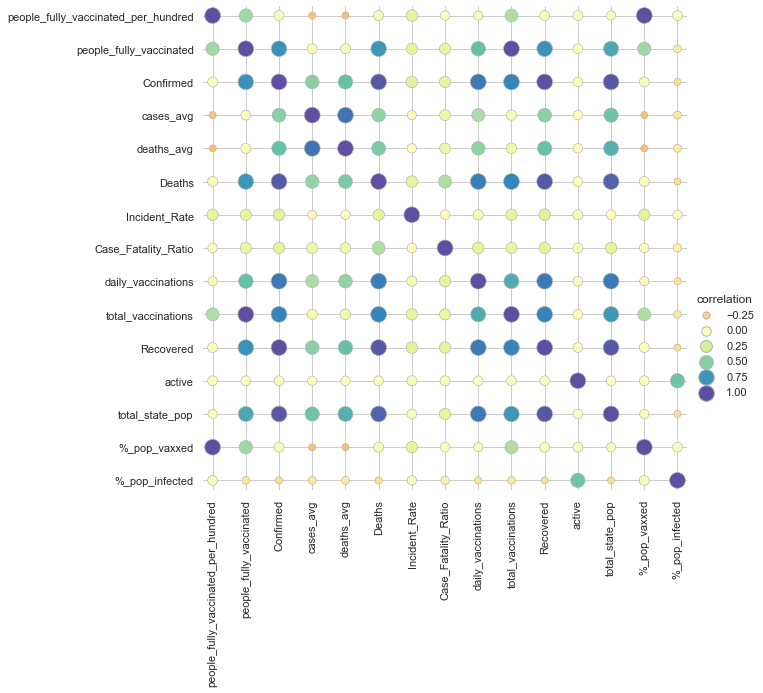

In [35]:
# Visualization of correlation matrix
corr_mat = tres.corr().stack().reset_index(name="correlation")

g = sns.relplot(
    data=corr_mat,
    x="level_0", y="level_1", hue="correlation", size="correlation",
    palette="Spectral", hue_norm=(-1, 1), edgecolor=".7",
    height=10, sizes=(50, 250), size_norm=(-.2, .8),
)

g.set(xlabel="", ylabel="", aspect="equal")
g.despine(left=True, bottom=True)
g.ax.margins(.02)
for label in g.ax.get_xticklabels():
    label.set_rotation(90)
for artist in g.legend.legendHandles:
    artist.set_edgecolor(".7")

The aim of our project was to predict safe travel destinations for Americans looking to get out after the Covid lockdowns. We collected data from https://www.bts.gov/browse-statistical-products-and-data/state-transportation-statistics/us-airline-traffic-airport
This provided the number of deplanements in each state for 2019 and 2020. We felt this was a good gauge of how travel had changed during the pandemic.

In [36]:
# reading travel change data
tch = pd.read_csv('TravelChangeData.csv')
# dropping military airports
tch = tch[~tch['Airport'].str.contains(r'NAF|AFS|AFB|AAF|MCAS')]
# dropping cols with no passenger info
tch = tch.drop(columns = ['Airport Country Name', 'Origin Airport Id', 'Origin State Abr', 'Freight tons', 'Latitude', 
                          'Longitude','Mail tons', 'Display City Market Name Full'])
# creating separate dataframes for each year's data
ptd = tch[tch['Year']== 2019].drop(columns = 'Year')
ptd = ptd.rename(columns={"Passengers": "Passengers 2019"})
ntd = tch[tch['Year'] == 2020].drop(columns = 'Year')
ntd = ntd.rename(columns={"Passengers": "Passengers 2020"})

#merging to compare years
ychd = pd.merge(ptd, ntd, on=['State' , 'Code', 'Airport', 'City'])
ychd = ychd.sort_values(by='State')
ychd.isnull().sum()

ychd['Passengers 2019'] = ychd['Passengers 2019'].interpolate(method='linear')
ychd['Passengers 2020'] = ychd['Passengers 2020'].interpolate(method='linear')

# summing values for each airport in each state
sych = ychd.drop(columns = ['Airport', 'City', 'Code'])
sych = sych.groupby(by='State').sum()
sych['Change'] = -(sych['Passengers 2019'] - sych['Passengers 2020'])
sych = sych.reset_index()
sych.head()

,State,Passengers 2019,Passengers 2020,Change
0,Alabama,2645096.0,797473.0,-1847623.0
1,Alaska,3814742.5,1401341.0,-2413401.5
2,Arizona,24850629.0,8880647.0,-15969982.0
3,Arkansas,2040658.0,637534.0,-1403124.0
4,California,104403549.0,28279957.0,-76123592.0


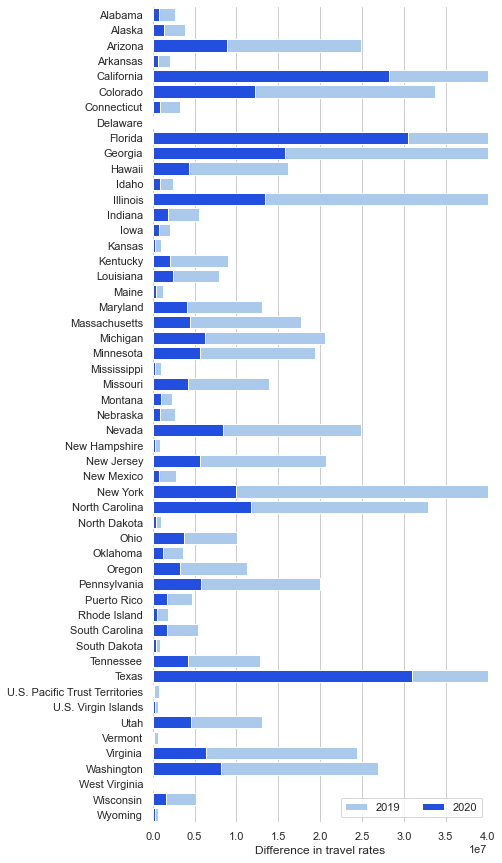

In [37]:
# Visualization of difference in number of travelers before and during the pandemic
sns.set_theme(style="whitegrid")

f, ax = plt.subplots(figsize=(6, 15))


sns.set_color_codes("pastel")
sns.barplot(x="Passengers 2019", y="State", data=sych,
            label="2019", color="b")


sns.set_color_codes("bright")
sns.barplot(x="Passengers 2020", y="State", data=sych,
            label="2020", color="b")

ax.legend(ncol=2, loc="lower right", frameon=True)
ax.set(xlim=(0, 40000000), ylabel="",
       xlabel="Difference in travel rates")
sns.despine(left=True, bottom=True)



The cell below is an example of a failed experiment. We would have liked to use GeoPandas for map visualizations, but there were conflicts between it and the version of Python that Jupyter is running.

In [38]:
#gdf = geopandas.GeoDataFrame(
#    sych, geometry=geopandas.points_from_xy(df.Longitude, df.Latitude))

Since we were hoping to provide travelers with information on safe travel, we gathered data on popular travel purposes. This dataset was sourced from https://www.bts.gov/browse-statistical-products-and-data/state-transportation-statistics/personal-travel and shows the purpose of travel for in-state travel per state in 2017. 

In [39]:
# reading travel purpose data
tpd = pd.read_csv('TravelPurposeData.csv')
tpd = tpd[tpd['Year']== 2017].drop(columns=['Number of Records'])
tpd = tpd.drop(columns =['Year'])
tpd.drop(tpd.index[tpd['State'] == 'United States'], inplace = True)
tpd.drop(tpd.index[tpd['Trip Purpose'] == 'Other'], inplace = True)
tpd.drop(tpd.index[tpd['Trip Purpose'] == 'School/Church'], inplace = True)
tpd.drop(tpd.index[tpd['Trip Purpose'] == 'Social/Recreational'], inplace = True)
tpd.drop(tpd.index[tpd['Trip Purpose'] == 'Work-related'], inplace = True)
tpd.drop(tpd.index[tpd['Trip Purpose'] == 'Work'], inplace = True)
tpd = tpd.drop(columns=['Trip Purpose', 'Number of Trips', 'Person miles (millions)', 'Person trips (millions)'])
tpd = tpd.rename(columns = {'Persons (thousands)': 'Travelers 2017'})
tpd['Travelers 2017'] = tpd['Travelers 2017'].astype('float64') * 1000
tpd.isnull().sum()
tpd.head()

,State,Travelers 2017
528,Alabama,4466000.0
534,Alaska,686000.0
540,Arizona,6382000.0
546,Arkansas,3084000.0
552,California,36632000.0


In the end, we decided not to incorporate the travel data. Although it might have been useful, we were not able to find a way to make it work with the vaccination statistics. We felt that the vaccine data should be the main focus of our prediction model.

In [40]:
#merging both travel datasets together
#trav = pd.merge(sych, tpd, on = ['State'])
#trav

In [41]:
tres.info()
#tres['state'].head(55)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9504 entries, 0 to 9503
Data columns (total 17 columns):
 #   Column                               Non-Null Count  Dtype         
---  ------                               --------------  -----         
 0   date                                 9504 non-null   datetime64[ns]
 1   state                                9504 non-null   object        
 2   people_fully_vaccinated_per_hundred  9504 non-null   float64       
 3   people_fully_vaccinated              9504 non-null   float64       
 4   Confirmed                            9504 non-null   float64       
 5   cases_avg                            9504 non-null   float64       
 6   deaths_avg                           9504 non-null   float64       
 7   Deaths                               9504 non-null   float64       
 8   Incident_Rate                        9504 non-null   float64       
 9   Case_Fatality_Ratio                  9504 non-null   float64       
 10  daily_vaccin

Our initial plan was to train a NN to make predictions about safe travel locations based on vaccination rates in each state, but we weren't sure of the best implementation. After some online research, we felt that an LSTM model would work well for taking in a large amount of data and predicting weeks into the future. All data needed to be in numeric form in order to use tensors.

We decided on the percentage of the population which is vaccinated as our y-value. The state and date are necessary features in order to predict for each one. We dropped most features in the dataframe since we were initially trying a univariant approach.


In [42]:
df_train = tres.copy()
#df_train = df_train.set_axis(df_train['date'])
df_train.state = df_train.state.map({'Alabama':0.0, 'Alaska':1.0, 'Arizona':2.0, 'Arkansas':3.0, 'California':4.0,
                                   'Colorado':5.0, 'Connecticut':6.0, 'Delaware':7.0, 'District of Columbia':8.0,
                                   'Florida':9.0, 'Georgia':10.0, 'Guam':11.0, 'Hawaii':12.0, 'Idaho':13.0, 'Illinois':14.0,
                                    'Indiana':15.0, 'Iowa':16.0, 'Kansas':17.0, 'Kentucky':18.0, 'Louisiana':19.0, 
                                    'Maine':20.0, 'Maryland':21.0, 'Massachusetts':22.0, 'Michigan':23.0, 'Minnesota':24.0,
                                    'Mississippi':25.0, 'Missouri':26.0, 'Montana':27.0, 'Nebraska':28.0, 'Nevada':29.0,
                                    'New Hampshire':30.0, 'New Jersey':31.0, 'New Mexico':32.0, 'New York':33.0, 
                                     'North Carolina':34.0,'North Dakota':35.0, 'Northern Mariana Islands':36.0, 
                                     'Ohio':37.0, 'Oklahoma':38.0,'Oregon':39.0, 'Pennsylvania':40.0, 'Puerto Rico':41.0, 
                                     'Rhode Island':42.0,'South Carolina':43.0, 'South Dakota':44.0, 'Tennessee':45.0, 
                                     'Texas':46.0, 'Utah':47.0,'Vermont':48.0, 'Virginia':49.0, 'Washington':50.0, 
                                     'West Virginia':51.0, 'Wisconsin':52.0,'Wyoming':53.0})

date_values = df_train['date'].values
state_data = df_train['state'].values
y_data = df_train['%_pop_vaxxed'].values
x_data = df_train.drop(['deaths_avg', 'Deaths', 'Case_Fatality_Ratio','total_vaccinations',
                       '%_pop_infected', 'Recovered', 'cases_avg', 'Confirmed',
                       'Incident_Rate', 'active', 'people_fully_vaccinated', 'people_fully_vaccinated_per_hundred',
                        'daily_vaccinations', 'total_state_pop'], axis=1)

In [43]:
#x_data = x_data.loc[1.0]
x_data

,date,state,%_pop_vaxxed
0,2021-01-12,0.0,0.15
1,2021-01-12,1.0,0.74
2,2021-01-12,2.0,0.11
3,2021-01-12,3.0,0.00
4,2021-01-12,4.0,0.25
...,...,...,...
9499,2021-07-06,49.0,52.47
9500,2021-07-06,50.0,55.24
9501,2021-07-06,51.0,37.47
9502,2021-07-06,52.0,50.34


In [44]:
#date_values = (date_values-date_values.min())/(date_values.max()-date_values.min())
#date_values

Our training data includes a date and the percentage of the population vaccinated for each state.


In [45]:
x_data['date'] = date_values
#x_data = x_data.drop(['date'], axis=1)
#x_data.stack
#x_data.reset_index()
x_data.set_index('state', inplace=True)
x_data

,date,%_pop_vaxxed
state,,
0.0,2021-01-12,0.15
1.0,2021-01-12,0.74
2.0,2021-01-12,0.11
3.0,2021-01-12,0.00
4.0,2021-01-12,0.25
...,...,...
49.0,2021-07-06,52.47
50.0,2021-07-06,55.24
51.0,2021-07-06,37.47


We split our data 80 training/20 testing, then scaled.

In [48]:
split_rate = 0.80
split = int(split_rate*len(x_data))

vax_data = x_data.values
vax_data = vax_data.reshape((-1,1))

scaler = MinMaxScaler()
scaler.fit(vax_data)
vax_data = scaler.fit_transform(vax_data)


X_train = vax_data[:split]
X_test = vax_data[split:]

dates = df_train['date'].values

date_train = df_train['date'][:split]
date_test = df_train['date'][split:]

#X_train.shape #(7462, 5)
#X_test.shape () #(1866,)

TypeError: float() argument must be a string or a number, not 'Timestamp'

The look back value is the number of days we are studying from the past in order to predict the future.

In [ ]:
look_back = 30

train_generator = TimeseriesGenerator(X_train, X_train, length=look_back, batch_size=15)
test_generator = TimeseriesGenerator(X_test, X_test, length=look_back, batch_size=1)

After trying many different configurations, the lowest loss model is with relu activation, adam optimizer, and mae loss.

In [ ]:
model = Sequential()
model.add(LSTM(100, activation='relu', input_shape=(look_back,1)))
model.add(Dense(10, activation ='relu'))
model.add(Dense(1))
model.compile(optimizer='adam', loss='mae')

In [ ]:
model.summary()

The model is very large. Training for more epochs results in less loss, but can take a considerable amount of time. For testing, we kept it between 50-100 epochs. Beyond 100 did not bring better results.

In [ ]:
model.fit(train_generator, epochs=100, verbose=1)

In [ ]:
loss_per_epoch = model.history.history['loss']
plt.plot(range(len(loss_per_epoch)), loss_per_epoch)

The following cell is a visualization of model training.

In [ ]:
pred = model.predict(test_generator)

X_train = X_train.reshape((-1))
X_test = X_test.reshape((-1))
pred = pred.reshape((-1))

dd = go.Scatter(
    x = date_train,
    y = X_train,
    mode = 'lines',
    name = 'Train data'
)
dd2 = go.Scatter(
    x = date_test,
    y = pred,
    mode = 'lines',
    name = 'Predicted'
)
dd3 = go.Scatter(
    x = date_test,
    y = X_test,
    mode='lines',
    name = 'True'
)

layout = go.Layout(
    title = "Predicted vaccinations",
    xaxis = {'title' : 'Date'},
    yaxis = {'title' : "Vaccinations"}
)

fig = go.Figure(data=[dd, dd2, dd3], layout=layout)
fig.show()

In [ ]:
vax_data = vax_data.reshape((-1))
vax_data.shape

The following cell is our prediction function. We intended to predict the vaccination rates for each state for the next 30 days.

In [ ]:
#vax_data = vax_data.reshape((-1))

def predict(num_prediction, model):
    predicted_list = vax_data[-look_back:]
    
    for _ in range(num_prediction):
        x = predicted_list[-look_back:]
        x = x.reshape((1, look_back, 1))
        output = model.predict(x)[0][0]
        predicted_list = np.append(predicted_list, output)
    predicted_list = predicted_list[look_back-1:]
    
    return predicted_list

def pred_dates(num_prediction):
    last_date = df_train['date'].values[-1]
    prediction_dates = pd.date_range(last_date, periods=num_prediction+1).tolist()
    return prediction_dates

num_prediction =30
forecast = predict(num_prediction, model)
forecast_dates = pred_dates(num_prediction)

print(forecast)
print("\n")
print(forecast_dates)

This output is not what we were expecting. We have tried many configurations, but it seems like this model is not a good fit for predicting the outcomes for 50 states over 30 days.


In [ ]:
pred = model.predict(test_generator)

X_train = X_train.reshape((-1))
X_test = X_test.reshape((-1))
pred = pred.reshape((-1))

dd = go.Scatter(
    x = date_train,
    y = X_train,
    mode = 'lines',
    name = 'Train data'
)
dd2 = go.Scatter(
    x = forecast_dates,
    y = forecast,
    mode = 'lines',
    name = 'Predicted'
)
dd3 = go.Scatter(
    x = date_test,
    y = X_test,
    mode='lines',
    name = 'True'
)

layout = go.Layout(
    title = "Predicted vaccinations",
    xaxis = {'title' : 'Date'},
    yaxis = {'title' : "Vaccinations"}
)

fig = go.Figure(data=[dd, dd2, dd3], layout=layout)
fig.show()

In [ ]:
pre = pd.DataFrame()
pre['date'] = forecast_dates
pre['state'] =xdf['state']
pre.set_index(['state','date'], inplace=True)
forecast = scaler.inverse_transform(forecast.reshape((-1,1)))
pre['Predicted_vaxxed'] = forecast

pre.stack
pre

We decided to try the LSTM with a multivariate approach.

In [ ]:
v_df = df_train.copy()

In [ ]:
v_df

In [ ]:
v_df = v_df.set_index(['date', 'state'])
v_df

In [ ]:
v_df = v_df.drop(['people_fully_vaccinated_per_hundred', 'Confirmed', 'cases_avg', 'deaths_avg', 'Deaths',
                 'Incident_Rate', 'Case_Fatality_Ratio', 'Recovered', 'active', '%_pop_infected'], axis=1)

In [ ]:
v_df

In [ ]:
scaley = StandardScaler()
scaley = scaley.fit(v_df)
vdf_sc = scaley.transform(v_df)

In [ ]:
trainX = []
trainY = []

In [ ]:
n_future = 30
n_past = 90

In [ ]:
for i in range (n_past, len(vdf_sc) - n_future+1):
    trainX.append(vdf_sc[i - n_past:i, 0:v_df.shape[1]])
    trainY.append(vdf_sc[i +n_future - 1:i + n_future, 0])
    
trainX, trainY = np.array(trainX), np.array(trainY)

In [ ]:
print('trainX shape == {}'.format(trainX.shape))
print('trainY shape == {}'.format(trainY.shape))

In [ ]:
model1 = Sequential()
model1.add(LSTM(100, activation='relu', input_shape=(trainX.shape[1], trainX.shape[2]), return_sequences=True))
model1.add(LSTM(50, activation='relu', return_sequences=False))
model1.add(Dropout(0.2))
model1.add(Dense(trainY.shape[1]))

model1.compile(optimizer='adam', loss='mse')
model1.summary()

In [ ]:
hist = model1.fit(trainX, trainY, epochs=10, batch_size=32, validation_split=0.1, verbose=1)

In [ ]:
plt.plot(hist.history['loss'], label='Training loss')
plt.plot(hist.history['val_loss'], label='validation loss')
plt.legend()

In [ ]:
n_future = 120
forecast_period_dates = pd.date_range(list(date_values)[-1], periods=n_future, freq='1d').tolist()

In [ ]:
big_forecast = model1.predict(trainX[-n_future:])

In [ ]:
copied_forecast = np.repeat(big_forecast, vdf_sc.shape[1], axis=-1)
y_pred_future = scaley.inverse_transform(copied_forecast)[:,4]
#y_pred_state_future = scaley.inverse_transform(copied_forecast)[:,2]

In [ ]:
forecast_days = []
for time_i in forecast_period_dates:
    forecast_days.append(time_i.date())

Unfortunately, the output for the multivariate was also not what we were hoping for. Despite our best attempts, it just doesn't seem like the LSTM model works well with the type of input we have. 

In [ ]:
df_forecast = pd.DataFrame({'Date':np.array(forecast_days),'%_vaxxed':y_pred_future})
df_forecast['Date'] = df_forecast['Date'].astype('datetime64[ns]')

df_forecast = df_forecast.set_index(['Date'])
#df_forecast['State'] = df_forecast['State'].round(0)
df_forecast

The following cells are examples of failed attempts that we made to make this model work for our purposes.


In [ ]:
#scaler = MinMaxScaler()

In [ ]:
'''
scaler.fit(X_train)
scaled_train = scaler.transform(X_train)
scaled_test = scaler.transform(X_test)
'''

In [ ]:
'''
num_input = 14
num_features = 1
generator = TimeseriesGenerator(scaled_train, scaled_train, length=num_input, batch_size=1)
'''

In [ ]:
'''
model = Sequential()
model.add(LSTM(100, activation='relu', input_shape=(num_input, num_features)))
model.add(Dense(1))
model.compile(optimizer='adam', loss='mse')
'''

In [ ]:
#model.summary()

In [ ]:
#model.fit(generator, epochs=10)

In [ ]:
#loss_per_epoch = model.history.history['loss']
#plt.plot(range(len(loss_per_epoch)), loss_per_epoch)

In [ ]:
#last_train_batch = scaled_train[-14:]

In [ ]:
#last_train_batch = last_train_batch.reshape((1, num_input, num_features))

In [ ]:
#model.predict(last_train_batch)

In [ ]:
#scaled_test[0]

In [ ]:
'''
test_predictions = []

first_eval_batch = scaled_train[-num_input:]
current_batch = first_eval_batch.reshape(1, num_input, num_features)

for i in range(len(X_test)):
    
    current_pred = model.predict(current_batch)[0]
    
    test_predictions.append(current_pred)
    
    current_batch = np.append(current_batch[:,1:,:],[[current_pred]],axis=1)
'''

In [ ]:
#test_predictions

In [ ]:
#X_test

In [ ]:
#tru_pred = scaler.inverse_transform(test_predictions)

In [ ]:
#X_test['Predicted_Vaxxed'] = tru_pred

In [ ]:
#X_test.plot(figsize=(10, 5))

In [ ]:
'''
y_true = X_test['%_pop_vaxxed'].values
y_pred = tru_pred

model_acc = r2_score(y_true, y_pred)
model_acc = np.round(model_acc, 2)
print("R2 Score(rough estimate model accuracy): ")
print(model_acc)
rmse=sqrt(mean_squared_error(X_test['%_pop_vaxxed'],X_test['Predicted_Vaxxed']))
print("Root_Mean_Squared_error: ")
print(round(rmse, 2))
'''

Our last ditch effort was to use the LSTM model for an individual state. Even though we can't predict the future for all 50 states individually, we can predict for a selected state.

In [ ]:
oneT = tres.loc[tres['state'] == 'Georgia']
oneT
v_data = oneT['%_pop_vaxxed'].values
v_data = v_data.reshape((-1,1))
print(v_data)
scaler = MinMaxScaler()
scaler.fit(v_data)
v_data = scaler.fit_transform(v_data)

split_per = 0.80
splitt = int(split_per*len(v_data))

v_train = v_data[:splitt]
v_test = v_data[splitt::]

d_train = oneT['date'][:splitt]
d_test = oneT['date'][splitt:]

look_bak = 25

train_gen = TimeseriesGenerator(v_train, v_train, length=look_bak, batch_size=10)     
test_gen = TimeseriesGenerator(v_test, v_test, length=look_bak, batch_size=1)

mod = Sequential()
mod.add(LSTM(100, activation='relu', input_shape=(look_bak,1)))
mod.add(Dense(10, activation='relu'))
mod.add(Dense(1))
mod.compile(optimizer='adam', loss='mse')


num_epochs = 500

mod.fit(train_gen, epochs=num_epochs, verbose=1)

loss_per_epoch = mod.history.history['loss']
plt.plot(range(len(loss_per_epoch)), loss_per_epoch)



In [ ]:
prediction = mod.predict(test_gen)

v_train = v_train.reshape((-1))
v_test = v_test.reshape((-1))
prediction = prediction.reshape((-1))

trace1 = go.Scatter(
    x = d_train,
    y = v_train*100,
    mode = 'lines',
    name = 'Training Data'
)
trace2 = go.Scatter(
    x = d_test,
    y = prediction*100,
    mode = 'lines',
    name = 'Prediction'
)
trace3 = go.Scatter(
    x = d_test,
    y = v_test*100,
    mode='lines',
    name = 'Actual'
)
layout = go.Layout(
    title = "Predicted Vaccinations",
    xaxis = {'title' : "Date"},
    yaxis = {'title' : "Percent Vaccinated"}
)
fig = go.Figure(data=[trace1, trace2, trace3], layout=layout)
fig.show()

From the figure above, we could already see that this model fit better with a smaller data set.

In [ ]:
v_data = v_data.reshape((-1))

def predict(num_prediction, model):
    prediction_list = v_data[-look_bak:]
    
    for _ in range(num_prediction):
        x = prediction_list[-look_bak:]
        x = x.reshape((1, look_bak, 1))
        out = model.predict(x)[0][0]
        prediction_list = np.append(prediction_list, out)
    prediction_list = prediction_list[look_bak-1:]
        
    return prediction_list
    
def predict_dates(num_prediction):
    last_date = oneT['date'].values[-1]
    prediction_dates = pd.date_range(last_date, periods=num_prediction+1).tolist()
    return prediction_dates

num_prediction = 30
forecastt = predict(num_prediction, mod)
forecastt_dates = predict_dates(num_prediction)
print(forecastt)
print(forecastt_dates)

In [ ]:
prediction = mod.predict(test_gen)

v_train = v_train.reshape((-1))
v_test = v_test.reshape((-1))
prediction = prediction.reshape((-1))

trace1 = go.Scatter(
    x = d_train,
    y = v_train*100,
    mode = 'lines',
    name = 'Training Data'
)
trace2 = go.Scatter(
    x = forecastt_dates,
    y = forecastt*100,
    mode = 'lines',
    name = 'Prediction'
)
trace3 = go.Scatter(
    x = d_test,
    y = v_test*100,
    mode='lines',
    name = 'Actual'
)
layout = go.Layout(
    title = "Predicted Vaccinations",
    xaxis = {'title' : "Date"},
    yaxis = {'title' : "Percent Vaccinated"}
)
fig = go.Figure(data=[trace1, trace2, trace3], layout=layout)
fig.show()

In [ ]:
preT = pd.DataFrame()
preT['date'] = forecastt_dates
preT['state'] =oneT['state']
preT.set_index(['state','date'], inplace=True)
forecastt = scaler.inverse_transform(forecastt.reshape((-1,1)))
preT['Predicted_vaxxed'] = forecastt

preT

Although we did not accomplish what we set out to do, we were able to make a reasonable prediction for the vaccination rate for an individual state. With further research, we could possibly build a model to predict for each state, but it was beyond the scope of our capabilities at this time.
